In [27]:
# ============================================================
# CELL 1: SETUP AND CONFIGURATION
# ============================================================
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# NEW IMPORTS FOR PIPELINE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CONFIGURATION
DATA_PATH = "suzukialto_repairtime_dataset.csv" 
MODEL_PATH = "repair_time_pipeline.pkl"
REPORT_PATH = "training_report.txt"
RANDOM_STATE = 42
N_SPLITS = 5

# Set visual style
sns.set_style("whitegrid")
print("✅ Libraries loaded and configuration set! (OneHotEncoder & ColumnTransformer added)")


✅ Libraries loaded and configuration set! (OneHotEncoder & ColumnTransformer added)


In [28]:
# ============================================================
# CELL 2: LOAD DATASET
# ============================================================
print("📂 STEP 1: Loading dataset...")
df = pd.read_csv(DATA_PATH)

print(f"✓ Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
print("\nFirst 3 rows of your data:")
display(df.head(10))


📂 STEP 1: Loading dataset...
✓ Loaded dataset with 875 rows and 15 columns

First 3 rows of your data:


,Record_ID,Car_Model,Model_Year,Mileage_KM,Fault_Category,Fault_Type,Severity,Parts_Required,Parts_Availability,Garage_Type,Mechanic_Expertise,Location,Day_of_Week,Time_of_Day,Actual_Repair_Hours
0,1,Suzuki Alto,2015,50303,Engine,Thermostat Stuck,Moderate,Thermostat Valve,In Stock,Local,15,Welipitiya,Saturday,Evening,2.7
1,2,Suzuki Alto,2019,201740,Engine,Misfiring,Moderate,Spark Plugs/Coils,In Stock,Authorized,17,Walgama,Friday,Afternoon,1.4
2,3,Suzuki Alto,2013,163706,AC,Blower Fan Issue,Moderate,Blower Motor,In Stock,Local,18,Thalalla,Saturday,Afternoon,1.0
3,4,Suzuki Alto,2019,51420,Body,Windshield Crack,Minor,Windshield Glass,In Stock,Authorized,14,Kotapola,Wednesday,Afternoon,1.5
4,5,Suzuki Alto,2021,79380,Brake,Brake Pad Wear,Moderate,Brake Pads,In Stock,Local,18,Nawimana,Sunday,Afternoon,0.9
5,6,Suzuki Alto,2011,210185,Brake,ABS Sensor Fault,Minor,ABS Sensor,In Stock,Authorized,15,Gandara,Wednesday,Evening,0.6
6,7,Suzuki Alto,2017,228011,Electrical,Headlight Issue,Minor,Bulb/Fuse,In Stock,Local,14,Welipitiya,Wednesday,Afternoon,0.5
7,8,Suzuki Alto,2011,216741,AC,No Cooling,Moderate,Refrigerant Gas,In Stock,Local,15,Kaduwela,Sunday,Morning,2.7
8,9,Suzuki Alto,2017,37015,Brake,Brake Shoe Wear,Minor,Brake Shoes,In Stock,Local,12,Kaduwela,Tuesday,Afternoon,0.9
9,10,Suzuki Alto,2018,157852,Body,Rust Patch,Minor,Tinkering/Painting,In Stock,Local,8,Kamburupitiya,Thursday,Afternoon,2.8


In [29]:
# ============================================================
# CELL 3: DATA CLEANING
# ============================================================
print("🧹 STEP 2: Checking for missing values...")

missing_count = df.isnull().sum().sum()

if missing_count > 0:
    print(f"⚠️ Found {missing_count} missing values. Filling...")
    for col in df.columns:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)


🧹 STEP 2: Checking for missing values...


In [30]:
# ============================================================
# CELL 4: DEFINE FEATURES (X) AND TARGET (y)
# ============================================================
print("📊 STEP 3 & 4: Defining Features...")

TARGET = "Actual_Repair_Hours"

# FIX: We drop 'Record_ID' because ID numbers are not useful for prediction
# We also drop the TARGET column to create our features (X)
X = df.drop([TARGET, "Record_ID"], axis=1)
y = df[TARGET]

print(f"✓ Defined X with {X.shape[0]} rows and {X.shape[1]} columns")
print(f"✓ Defined y (Target: {TARGET})")

# VIVA VISUALIZATION: Show Raw Data
print("\n🔍 VIVA DEMO: The model will automatically encode these columns:")
categorical_cols = X.select_dtypes(include="object").columns.tolist()
display(X[categorical_cols].head(3))

📊 STEP 3 & 4: Defining Features...
✓ Defined X with 875 rows and 13 columns
✓ Defined y (Target: Actual_Repair_Hours)

🔍 VIVA DEMO: The model will automatically encode these columns:


,Car_Model,Fault_Category,Fault_Type,Severity,Parts_Required,Parts_Availability,Garage_Type,Location,Day_of_Week,Time_of_Day
0,Suzuki Alto,Engine,Thermostat Stuck,Moderate,Thermostat Valve,In Stock,Local,Welipitiya,Saturday,Evening
1,Suzuki Alto,Engine,Misfiring,Moderate,Spark Plugs/Coils,In Stock,Authorized,Walgama,Friday,Afternoon
2,Suzuki Alto,AC,Blower Fan Issue,Moderate,Blower Motor,In Stock,Local,Thalalla,Saturday,Afternoon


In [31]:
# ============================================================
# CELL 5: CREATE SMART PIPELINE (AUTO-DETECT)
# ============================================================
print("🤖 STEP 5: Initializing Smart Pipeline...")

# 1. Automatically identify Categorical (Text) columns
# This looks at YOUR actual data, so it finds 'Location' automatically.
categorical_features = X.select_dtypes(include="object").columns.tolist()

print(f"   ➤ Auto-Detected Text Columns: {categorical_features}")

# 2. Create Preprocessor (Encodes Text -> Numbers)
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

# 3. Create Pipeline (Preprocessor + Model)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("✓ Smart Pipeline Created.")

🤖 STEP 5: Initializing Smart Pipeline...
   ➤ Auto-Detected Text Columns: ['Car_Model', 'Fault_Category', 'Fault_Type', 'Severity', 'Parts_Required', 'Parts_Availability', 'Garage_Type', 'Location', 'Day_of_Week', 'Time_of_Day']
✓ Smart Pipeline Created.


In [32]:
# ============================================================
# CELL 6: K-FOLD VALIDATION (ON RAW DATA)
# ============================================================
print("🎯 STEP 6: Running K-Fold Validation...")

kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
scoring = {"mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error", "r2": "r2"}

# NOTE: We pass 'X' (Raw), not X_encoded
cv_results = cross_validate(pipeline, X, y, cv=kfold, scoring=scoring, return_train_score=False)

mae = -cv_results["test_mae"]
rmse = -cv_results["test_rmse"]
r2 = cv_results["test_r2"]

print("-" * 85)
print(f"{'ITERATION':<15} {'MAE (Hours)':<20} {'RMSE (Hours)':<20} {'ACCURACY (R²)':<15}")
print("-" * 85)
for i in range(N_SPLITS):
    print(f"Fold {i+1:<10} {mae[i]:<20.4f} {rmse[i]:<20.4f} {r2[i]:<15.4f}")
print("-" * 85)
print(f"AVERAGE        {mae.mean():.4f} ± {mae.std():.2f}     {rmse.mean():.4f} ± {rmse.std():.2f}     {r2.mean():.4f} ± {r2.std():.2f}")

🎯 STEP 6: Running K-Fold Validation...
-------------------------------------------------------------------------------------
ITERATION       MAE (Hours)          RMSE (Hours)         ACCURACY (R²)  
-------------------------------------------------------------------------------------
Fold 1          0.9888               1.8875               0.9423         
Fold 2          1.4804               4.3614               0.7970         
Fold 3          1.3065               2.8540               0.9240         
Fold 4          1.2531               3.9066               0.7810         
Fold 5          1.6429               4.8124               0.6517         
-------------------------------------------------------------------------------------
AVERAGE        1.3343 ± 0.22     3.5644 ± 1.06     0.8192 ± 0.11


📊 STEP 7: Generating Stability Graph...


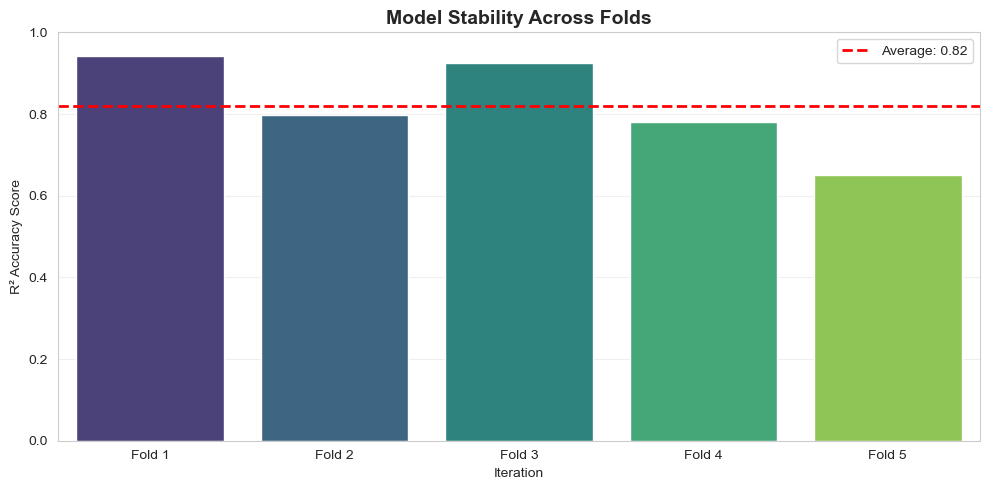

✅ Stability Graph Generated!


In [33]:
# ============================================================
# CELL 7: STABILITY GRAPH (Fixed Variable Name)
# ============================================================
print("📊 STEP 7: Generating Stability Graph...")

plt.figure(figsize=(10, 5))

# Create Labels
folds_labels = [f"Fold {i+1}" for i in range(N_SPLITS)]

# FIX: Use 'r2' instead of 'r2_scores'
sns.barplot(x=folds_labels, y=r2, hue=folds_labels, palette="viridis", legend=False)

# Add Average Line
plt.axhline(y=r2.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {r2.mean():.2f}')

plt.title('Model Stability Across Folds', fontsize=14, fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('R² Accuracy Score')
plt.ylim(0, 1) 
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Stability Graph Generated!")

📊 Generating 3x2 Grid...


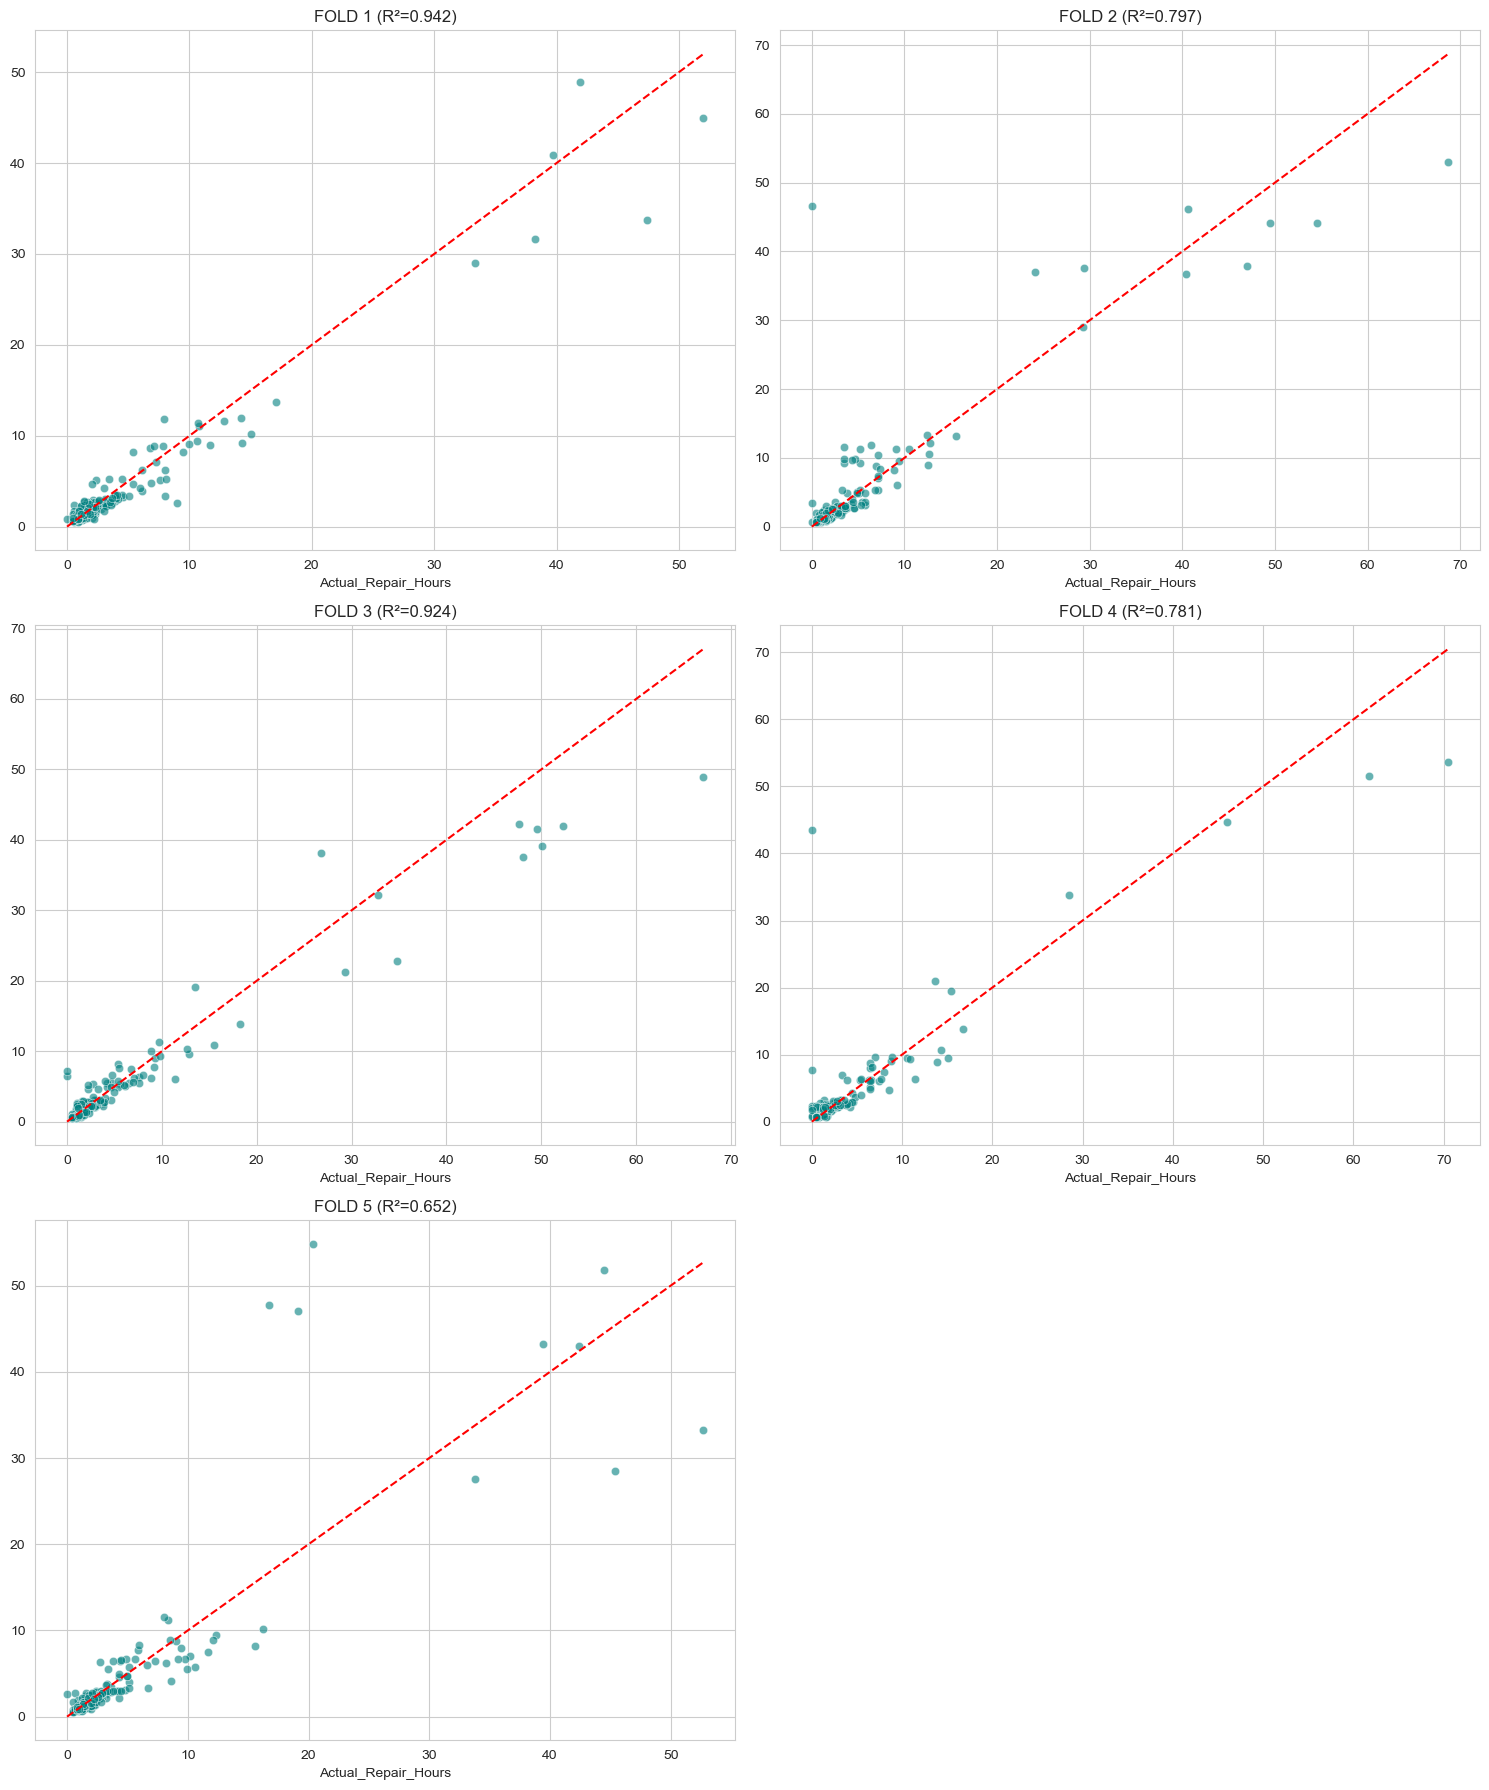

In [34]:
# ============================================================
# CELL 8: GRID SCATTER PLOTS (3x2)
# ============================================================
print("📊 Generating 3x2 Grid...")
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

# CRITICAL UPDATE: Split 'X' (Raw), not 'X_encoded'
for i, (tr_idx, te_idx) in enumerate(kfold.split(X, y)):
    # Slice the raw dataframe
    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    
    # Fit pipeline on this fold's training data
    pipeline.fit(X_tr, y_tr)
    # Predict on this fold's test data
    pred = pipeline.predict(X_te)
    
    ax = axes[i]
    sns.scatterplot(x=y_te, y=pred, ax=ax, color='teal', alpha=0.6)
    ax.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--')
    ax.set_title(f"FOLD {i+1} (R²={r2_score(y_te, pred):.3f})")

axes[5].axis('off')
plt.tight_layout()
plt.show()

In [35]:
# ============================================================
# CELL 9: FINAL TRAINING
# ============================================================
print("🎓 STEP 9: Training Final Model on Full Data...")

# The pipeline handles the One-Hot Encoding automatically here
pipeline.fit(X, y) 

print("✓ Final model trained successfully.")

🎓 STEP 9: Training Final Model on Full Data...
✓ Final model trained successfully.


📊 Generating Hero Image...


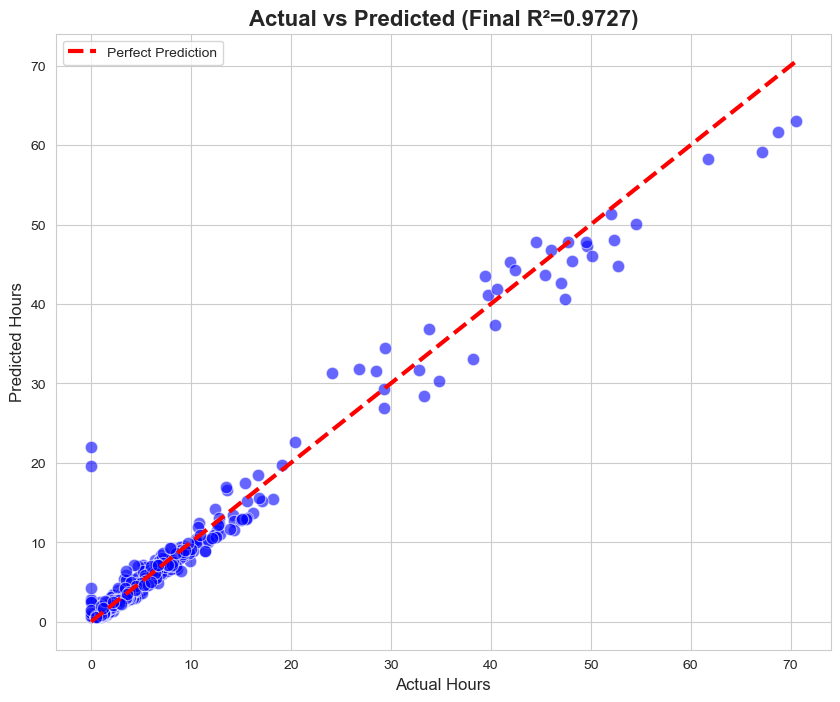

In [36]:
# ============================================================
# CELL 10: HERO GRAPH (ACTUAL VS PREDICTED)
# ============================================================
print("📊 Generating Hero Image...")

# Predict on the full raw dataset
y_final = pipeline.predict(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y, y=y_final, color='blue', alpha=0.6, s=80)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=3, label='Perfect Prediction')

plt.title(f'Actual vs Predicted (Final R²={r2_score(y, y_final):.4f})', fontsize=16, fontweight='bold')
plt.xlabel('Actual Hours', fontsize=12)
plt.ylabel('Predicted Hours', fontsize=12)
plt.legend()

# Save the high-quality image
plt.savefig("actual_vs_predicted_final.png", dpi=300)
plt.show()

📊 STEP 11: Generating & Saving Advanced Error Analysis...
   ➤ Generating Combined Vertical Summary...


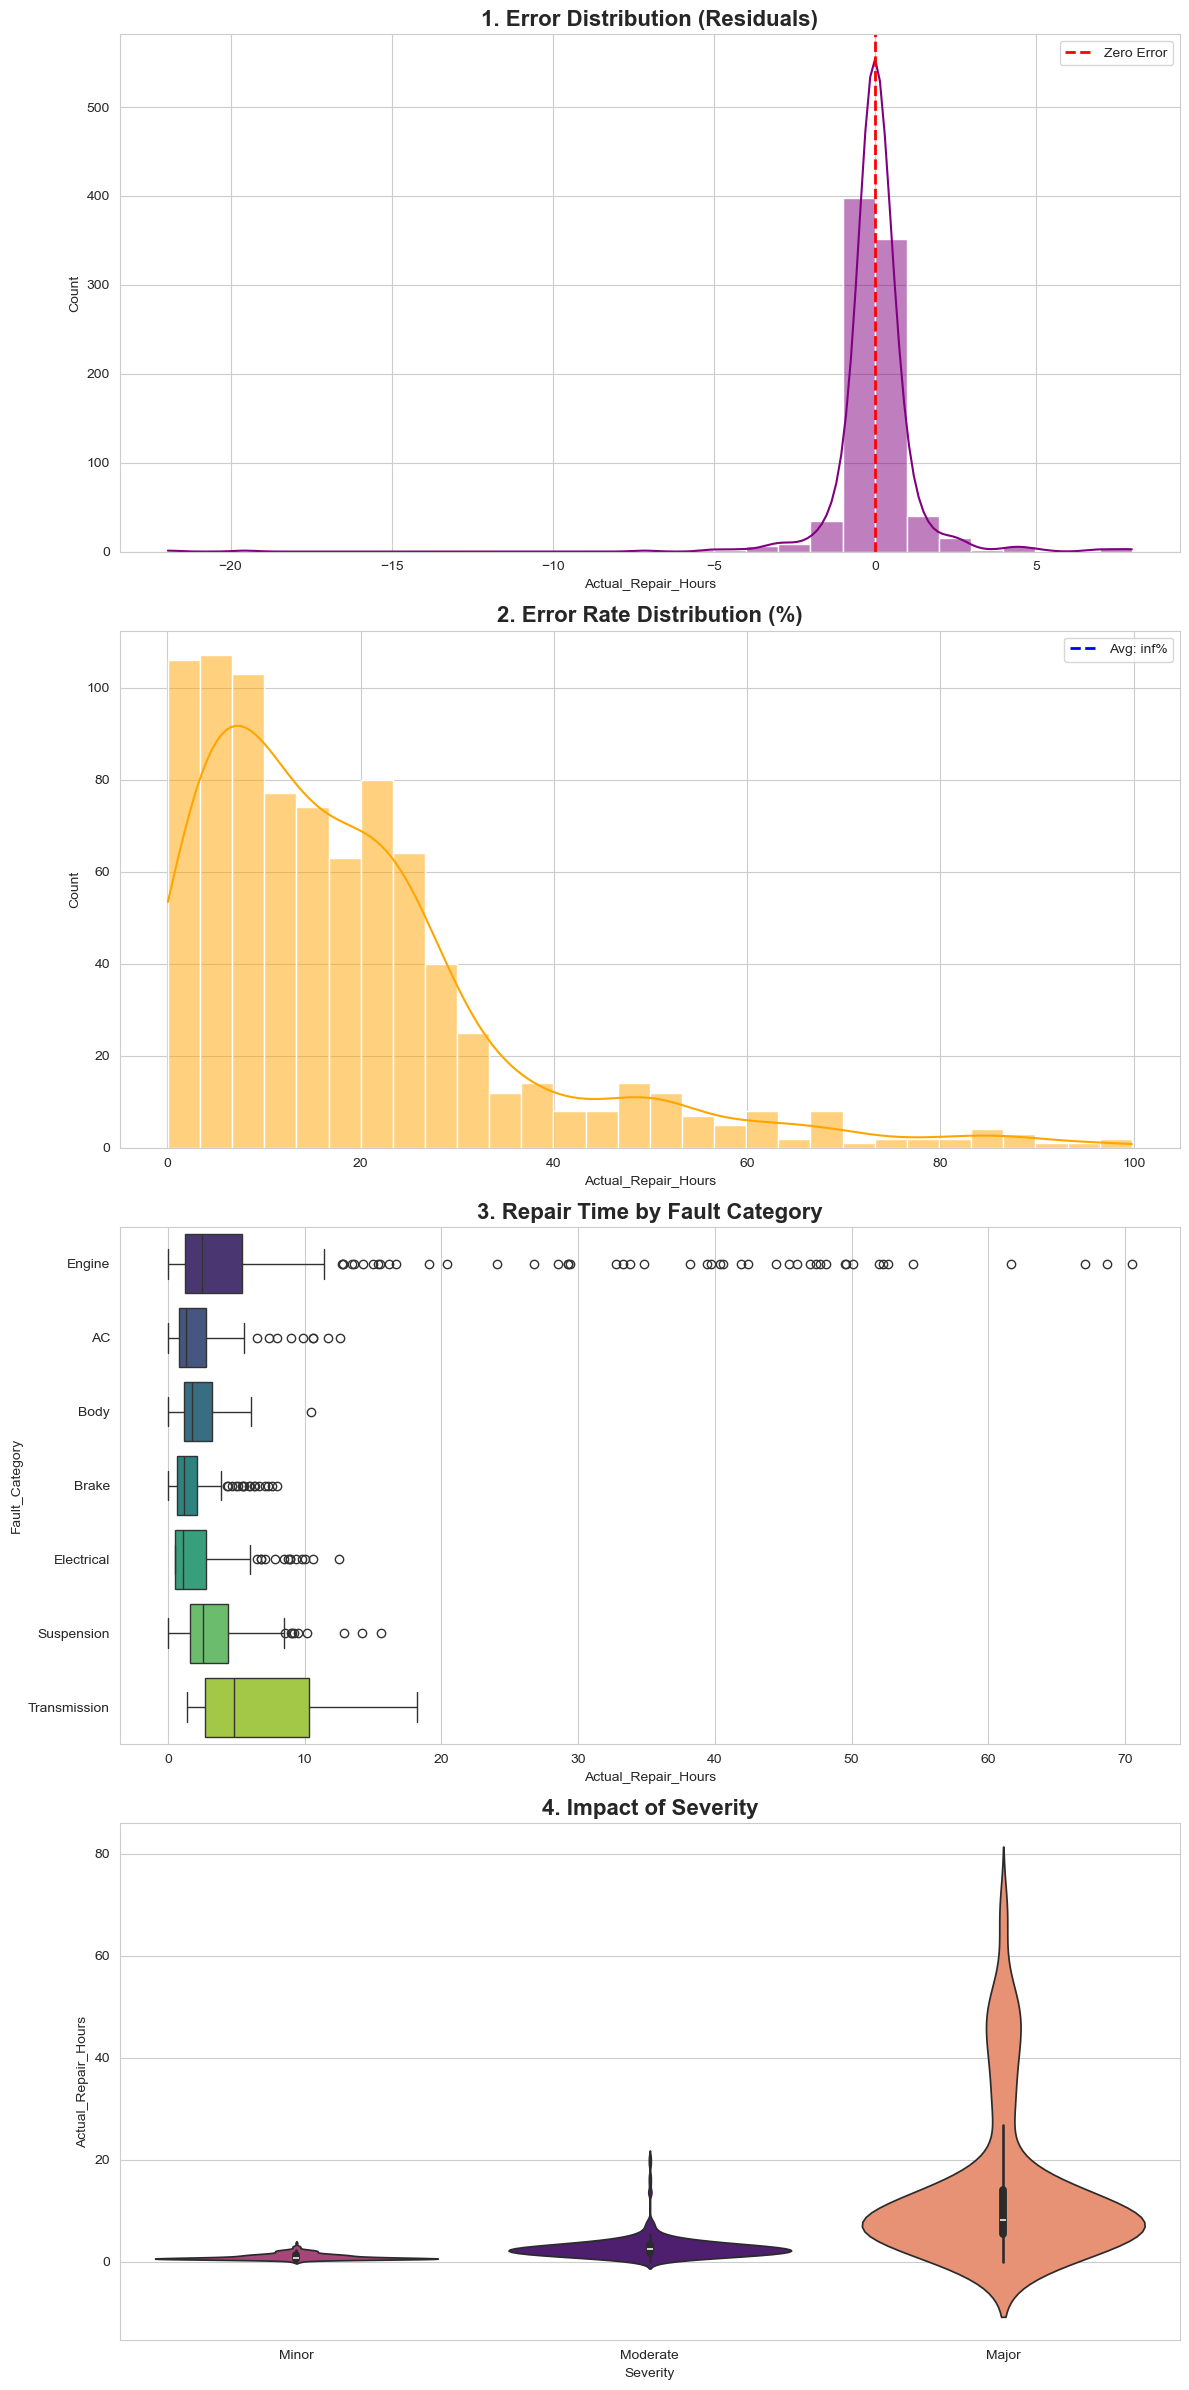

   ➤ Saving Individual Graphs (Background)...
✅ All 5 files saved successfully!


In [37]:
# ============================================================
# CELL 11: ERROR METRICS, SAVING & SHOWING GRAPHS
# ============================================================
print("📊 STEP 11: Generating & Saving Advanced Error Analysis...")

# 1. Calculate Metrics
y_pred_final = pipeline.predict(X)
residuals = y - y_pred_final
abs_errors = np.abs(residuals)
pct_errors = (abs_errors / y) * 100 

# =======================================================
# PART A: GENERATE, SAVE & SHOW COMBINED SUMMARY
# =======================================================
print("   ➤ Generating Combined Vertical Summary...")
plt.figure(figsize=(12, 24)) 

# Graph 1
plt.subplot(4, 1, 1)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('1. Error Distribution (Residuals)', fontsize=16, fontweight='bold')
plt.legend()

# Graph 2
plt.subplot(4, 1, 2)
sns.histplot(pct_errors[pct_errors < 100], kde=True, color='orange', bins=30)
plt.axvline(pct_errors.mean(), color='blue', linestyle='--', linewidth=2, label=f'Avg: {pct_errors.mean():.1f}%')
plt.title('2. Error Rate Distribution (%)', fontsize=16, fontweight='bold')
plt.legend()

# Graph 3 (With Fix for Warnings)
plt.subplot(4, 1, 3)
sns.boxplot(x='Actual_Repair_Hours', y='Fault_Category', data=df, palette='viridis', hue='Fault_Category', legend=False)
plt.title('3. Repair Time by Fault Category', fontsize=16, fontweight='bold')

# Graph 4 (With Fix for Warnings)
plt.subplot(4, 1, 4)
sns.violinplot(x='Severity', y='Actual_Repair_Hours', data=df, palette='magma', hue='Severity', legend=False, order=['Minor', 'Moderate', 'Major'])
plt.title('4. Impact of Severity', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.savefig("detailed_error_analysis_vertical.png", dpi=300)
plt.show() 

# =======================================================
# PART B: SAVE EACH GRAPH INDIVIDUALLY (Silent)
# =======================================================
print("   ➤ Saving Individual Graphs (Background)...")

# 1. Error Dist
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.title('Error Distribution', fontsize=14, fontweight='bold')
plt.savefig("graph1_error_distribution.png", dpi=300)
plt.close()

# 2. Error Rate
plt.figure(figsize=(10, 6))
sns.histplot(pct_errors[pct_errors < 100], kde=True, color='orange', bins=30)
plt.axvline(pct_errors.mean(), color='blue', linestyle='--')
plt.title('Error Rate Distribution', fontsize=14, fontweight='bold')
plt.savefig("graph2_error_rate.png", dpi=300)
plt.close()

# 3. Fault Cat
plt.figure(figsize=(10, 8)) 
sns.boxplot(x='Actual_Repair_Hours', y='Fault_Category', data=df, palette='viridis', hue='Fault_Category', legend=False)
plt.title('Repair Time by Category', fontsize=14, fontweight='bold')
plt.savefig("graph3_fault_category.png", dpi=300)
plt.close()

# 4. Severity
plt.figure(figsize=(10, 6))
sns.violinplot(x='Severity', y='Actual_Repair_Hours', data=df, palette='magma', hue='Severity', legend=False, order=['Minor', 'Moderate', 'Major'])
plt.title('Impact of Severity', fontsize=14, fontweight='bold')
plt.savefig("graph4_severity_impact.png", dpi=300)
plt.close()

print("✅ All 5 files saved successfully!")

In [38]:
# ============================================================
# CELL 12: SAVE ARTIFACTS
# ============================================================
print("💾 STEP 12: Saving Smart Pipeline...")

with open(MODEL_PATH, "wb") as f:
    pickle.dump(pipeline, f)

print(f"✓ Model saved as: {MODEL_PATH}")
print("🚀 DONE! Your model is now ready for the Chatbot.")

💾 STEP 12: Saving Smart Pipeline...
✓ Model saved as: repair_time_pipeline.pkl
🚀 DONE! Your model is now ready for the Chatbot.


In [39]:
print(df.columns.tolist())

['Record_ID', 'Car_Model', 'Model_Year', 'Mileage_KM', 'Fault_Category', 'Fault_Type', 'Severity', 'Parts_Required', 'Parts_Availability', 'Garage_Type', 'Mechanic_Expertise', 'Location', 'Day_of_Week', 'Time_of_Day', 'Actual_Repair_Hours']


🧪 STEP 13: Testing the Model with a Real Example...


ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.